In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
import numpy as np

In [101]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
class PatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config.img_size
        self.patch_size = config.patch_size
        self.d_embed = config.d_embed
        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.conv = nn.Conv2d(3, self.d_embed, kernel_size=self.patch_size, stride=self.patch_size) 
        
    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        return self.conv(x).flatten(2).transpose(1, 2) 

In [78]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        n_heads, d_embed, dropout_attn, dropout_proj, device = config.n_heads, config.d_embed, config.dropout_attn, config.dropout_proj, config.device

        assert d_embed % n_heads == 0        
        self.hid_dim = d_embed
        self.n_heads = n_heads
        self.head_dim = d_embed // n_heads
        
        self.fc_q = nn.Linear(d_embed, d_embed)
        self.fc_k = nn.Linear(d_embed, d_embed)
        self.fc_v = nn.Linear(d_embed, d_embed)
        self.proj = nn.Linear(d_embed, d_embed)
        
        self.dropout_attn = nn.Dropout(dropout_attn)
        self.dropout_proj = nn.Dropout(dropout_proj)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, x, mask = None):       
        batch_size = x.shape[0]

        Q,K,V = self.fc_q(x), self.fc_k(x), self.fc_v(x) #[batch size, query len, hid dim
    
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) # [batch size, n heads, query len, head dim]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) 
                
        attention = torch.matmul(Q, K.permute(0, 1, 3, 2)) /  self.scale  #attention = [batch size, n heads, query len, key len]
        
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float('-inf'))
        
        attention = self.dropout_attn(torch.softmax(attention, dim = -1)) # Attention Dropout;  attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(attention, V) #x = [batch size, n heads, query len, head dim]
        x = x.permute(0, 2, 1, 3).contiguous() #x = [batch size, query len, n heads, head dim]
        x = x.view(batch_size, -1, self.hid_dim) #x = [batch size, query len, hid dim] (hidden concat of all heads)
        x = self.dropout_proj(self.proj(x)) #x = [batch size, query len, hid dim]

        return x #,attention

In [79]:
class EncoderBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.mhsa = MultiHeadedSelfAttention(config)
        self.pwff = nn.Sequential(
            nn.Linear(config.d_embed, config.d_ff),
            nn.GELU(),
            nn.Linear(config.d_ff, config.d_embed),
            nn.Dropout(config.dropout_pwff)
        )
        self.ln_mhsa = nn.LayerNorm(config.d_embed)
        self.ln_pwff = nn.LayerNorm(config.d_embed)
        self.dropout = nn.Dropout(config.dropout_res)

    def forward(self, x, mask=None):
        x = x + self.dropout(self.mhsa(self.ln_mhsa(x)))   # Pre-LN
        x = x + self.dropout(self.pwff(self.ln_pwff(x)))
        return x

In [80]:
class ViT(nn.Module):
    """Vision Transformer."""
    def __init__(self, config):
        super().__init__()
        self.patch_embedding = PatchEmbedding(config)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.d_embed))
        num_tokens = self.patch_embedding.num_patches + 1  # Add the cls token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_tokens, config.d_embed))
        self.dropout = nn.Dropout(config.dropout_emb)
        self.enc_blocks = nn.ModuleList([EncoderBlock(config) for _ in range(config.enc_blocks)])
        self.head = nn.Sequential(nn.LayerNorm(config.d_embed), nn.Linear(config.d_embed, config.num_classes))

    def forward(self, x):
        x = self.patch_embedding(x)
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), 1)
        x = self.dropout(x + self.pos_embedding)
        for enc_block in self.enc_blocks:
            x = enc_block(x)
        return self.head(x[:, 0])

In [177]:
from dataclasses import dataclass

@dataclass
class ModelConfig:
    d_embed: int
    d_ff: int
    n_heads: int
    enc_blocks: int
    img_size: int
    patch_size: int
    num_classes: int
    dropout_res: float
    dropout_attn: float
    dropout_proj: float
    dropout_emb: float
    dropout_pwff: float
    device: str

config = ModelConfig(
    d_embed = 32,
    d_ff = 4*32,
    n_heads = 8,
    img_size = 32,
    patch_size= 2,
    enc_blocks = 4,
    num_classes = 10,
    dropout_res = 0.1,
    dropout_attn = 0.1,
    dropout_proj= 0.1,
    dropout_emb=  0.1,
    dropout_pwff = 0.1,
    device="cuda"
)

In [178]:
model = ViT(config)
model = model.to("cuda")

In [179]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [166]:
from statistics import mean

In [180]:
from tqdm import tqdm
losses_train = []
losses_test = []
for epoch in range(100):  # loop over the dataset multiple times
    _train_lossses=[]
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to("cuda")
        labels = labels.to("cuda")
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        _train_lossses.append(loss.item())

    with torch.no_grad():
        _test_losses=[]
        for data in tqdm(testloader):
            images, labels = data
            images = images.to("cuda")
            labels = labels.to("cuda")
            # calculate outputs by running images through the network
            outputs = model(images)
            test_loss = criterion(outputs,labels)
            _test_losses.append(test_loss.item())
        losses_test.append(mean(_test_losses))
            
        # if i % 196 == 195:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        #     running_loss = 0.0
    losses_train.append(mean(_train_lossses))
    print(f"epoch {epoch} train loss = {losses_train[-1]}")
    print(f"epoch {epoch} test loss = {losses_test[-1]}")
    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data in tqdm(testloader):
    #         images, labels = data
    #         images = images.to("cuda")
    #         labels = labels.to("cuda")
    #         # calculate outputs by running images through the network
    #         outputs = model(images)
    #         # the class with the highest energy is what we choose as prediction
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()
    # print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

print('Finished Training')

196it [01:03,  3.07it/s]
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]


epoch 0 train loss = 1.940122739392884
epoch 0 test loss = 1.742974054813385


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


epoch 1 train loss = 1.6930594851776046
epoch 1 test loss = 1.5906618744134904


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 2 train loss = 1.5608889959296401
epoch 2 test loss = 1.4887420862913132


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 3 train loss = 1.4839813709259033
epoch 3 test loss = 1.4473899722099304


196it [01:03,  3.10it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 4 train loss = 1.4153378934276348
epoch 4 test loss = 1.3972768783569336


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 5 train loss = 1.3656446927664232
epoch 5 test loss = 1.3493661493062974


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 6 train loss = 1.318054412700692
epoch 6 test loss = 1.298136168718338


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 7 train loss = 1.275936130966459
epoch 7 test loss = 1.3125485599040985


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 8 train loss = 1.2436878687264967
epoch 8 test loss = 1.257822984457016


196it [01:03,  3.07it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 9 train loss = 1.2032756008663956
epoch 9 test loss = 1.2103336840867995


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]


epoch 10 train loss = 1.1706724139500637
epoch 10 test loss = 1.1752688497304917


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 11 train loss = 1.1469547973603618
epoch 11 test loss = 1.1903670102357864


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 12 train loss = 1.1269513730491911
epoch 12 test loss = 1.1455669164657594


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


epoch 13 train loss = 1.0933138563924907
epoch 13 test loss = 1.1275578081607818


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 14 train loss = 1.0678511337966334
epoch 14 test loss = 1.1150738194584846


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 15 train loss = 1.0571274952012666
epoch 15 test loss = 1.1819162994623185


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 16 train loss = 1.0340331522177677
epoch 16 test loss = 1.1314328864216805


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


epoch 17 train loss = 1.0113973197888355
epoch 17 test loss = 1.0795228496193885


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 18 train loss = 0.9960138946771622
epoch 18 test loss = 1.0479458525776864


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 19 train loss = 0.983663544362905
epoch 19 test loss = 1.0636861011385919


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.00it/s]


epoch 20 train loss = 0.9601980493384965
epoch 20 test loss = 1.0493576854467392


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 21 train loss = 0.9444583082685665
epoch 21 test loss = 1.0320068776607514


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


epoch 22 train loss = 0.9345099478960037
epoch 22 test loss = 1.0141386702656745


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


epoch 23 train loss = 0.9185668035429351
epoch 23 test loss = 1.0197104975581168


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


epoch 24 train loss = 0.9076057505242678
epoch 24 test loss = 1.0262231349945068


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


epoch 25 train loss = 0.8925946567739759
epoch 25 test loss = 0.9680291101336479


196it [01:04,  3.03it/s]
100%|██████████| 40/40 [00:05<00:00,  6.85it/s]


epoch 26 train loss = 0.8892619664571724
epoch 26 test loss = 0.995248843729496


196it [01:04,  3.04it/s]
100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


epoch 27 train loss = 0.8751740218425283
epoch 27 test loss = 0.9996488943696022


196it [01:03,  3.06it/s]
100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


epoch 28 train loss = 0.8656235747799581
epoch 28 test loss = 0.9596620574593544


196it [01:03,  3.07it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 29 train loss = 0.8568605516029864
epoch 29 test loss = 0.9754123643040657


196it [01:03,  3.10it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 30 train loss = 0.8447643153521479
epoch 30 test loss = 0.970204921066761


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 31 train loss = 0.8384064594093634
epoch 31 test loss = 0.980829419195652


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 32 train loss = 0.8321192942711771
epoch 32 test loss = 0.947392538189888


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 33 train loss = 0.8269775512875343
epoch 33 test loss = 0.9632150068879127


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


epoch 34 train loss = 0.816292693116227
epoch 34 test loss = 0.9800677314400673


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.98it/s]


epoch 35 train loss = 0.8120911738702229
epoch 35 test loss = 0.9489795953035355


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 36 train loss = 0.807541090919047
epoch 36 test loss = 0.9214377000927925


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 37 train loss = 0.7977446664352806
epoch 37 test loss = 0.97166106402874


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.09it/s]


epoch 38 train loss = 0.7971872021349109
epoch 38 test loss = 0.9367776706814765


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 39 train loss = 0.783519809343377
epoch 39 test loss = 0.9378376886248588


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 40 train loss = 0.7794041016272136
epoch 40 test loss = 0.9412903383374214


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 41 train loss = 0.7777624753664951
epoch 41 test loss = 0.9557913944125176


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.95it/s]


epoch 42 train loss = 0.7731004722264349
epoch 42 test loss = 0.9216069549322128


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 43 train loss = 0.7679167779124513
epoch 43 test loss = 0.9205767408013343


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


epoch 44 train loss = 0.7533549724184737
epoch 44 test loss = 0.9240756124258042


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 45 train loss = 0.7520748005837811
epoch 45 test loss = 0.9064355179667473


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 46 train loss = 0.7506173313880453
epoch 46 test loss = 0.9307303503155708


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 47 train loss = 0.7421056457928249
epoch 47 test loss = 0.922893314063549


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


epoch 48 train loss = 0.7439628140050538
epoch 48 test loss = 0.906948758661747


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.08it/s]


epoch 49 train loss = 0.7388245454248117
epoch 49 test loss = 0.9377332270145416


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 50 train loss = 0.733157787091878
epoch 50 test loss = 0.919952355325222


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.00it/s]


epoch 51 train loss = 0.7261824498371202
epoch 51 test loss = 0.9214814141392708


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  6.97it/s]


epoch 52 train loss = 0.7283709678722887
epoch 52 test loss = 0.8757079929113388


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 53 train loss = 0.72389603299754
epoch 53 test loss = 0.9099227085709571


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 54 train loss = 0.7241723951028318
epoch 54 test loss = 0.9286611542105675


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  6.91it/s]


epoch 55 train loss = 0.7127300336652872
epoch 55 test loss = 0.938607594370842


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 56 train loss = 0.7147331380722474
epoch 56 test loss = 0.9165164530277252


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.02it/s]


epoch 57 train loss = 0.7067903885427786
epoch 57 test loss = 0.9102778151631356


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 58 train loss = 0.7049906202116791
epoch 58 test loss = 0.9086463883519172


196it [01:03,  3.10it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 59 train loss = 0.7063377663797262
epoch 59 test loss = 0.8926156744360924


196it [01:04,  3.05it/s]
100%|██████████| 40/40 [00:05<00:00,  6.87it/s]


epoch 60 train loss = 0.6941517472875361
epoch 60 test loss = 0.8799669563770294


196it [01:04,  3.03it/s]
100%|██████████| 40/40 [00:05<00:00,  6.86it/s]


epoch 61 train loss = 0.6943110990889219
epoch 61 test loss = 0.8984692484140396


196it [01:03,  3.07it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 62 train loss = 0.690938939549485
epoch 62 test loss = 0.9253042802214623


196it [01:03,  3.10it/s]
100%|██████████| 40/40 [00:05<00:00,  7.12it/s]


epoch 63 train loss = 0.6937620204930403
epoch 63 test loss = 0.8911638781428337


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 64 train loss = 0.6880386602513644
epoch 64 test loss = 0.9003334805369377


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.04it/s]


epoch 65 train loss = 0.687090089126509
epoch 65 test loss = 0.9048813462257386


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.05it/s]


epoch 66 train loss = 0.6763350705102998
epoch 66 test loss = 0.9266765892505646


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 67 train loss = 0.6781919668523633
epoch 67 test loss = 0.9042808875441551


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.07it/s]


epoch 68 train loss = 0.675372949364234
epoch 68 test loss = 0.8980997905135155


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 69 train loss = 0.6760441773400014
epoch 69 test loss = 0.8722835421562195


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  7.03it/s]


epoch 70 train loss = 0.6690333233195909
epoch 70 test loss = 0.8813617035746575


196it [01:03,  3.10it/s]
100%|██████████| 40/40 [00:05<00:00,  7.06it/s]


epoch 71 train loss = 0.6712697814313733
epoch 71 test loss = 0.911884044110775


196it [01:03,  3.09it/s]
100%|██████████| 40/40 [00:05<00:00,  6.99it/s]


epoch 72 train loss = 0.6683254640321342
epoch 72 test loss = 0.8991930082440376


196it [01:03,  3.08it/s]
100%|██████████| 40/40 [00:05<00:00,  7.01it/s]


epoch 73 train loss = 0.6685461163216707
epoch 73 test loss = 0.908707657456398


191it [01:02,  3.06it/s]


KeyboardInterrupt: 

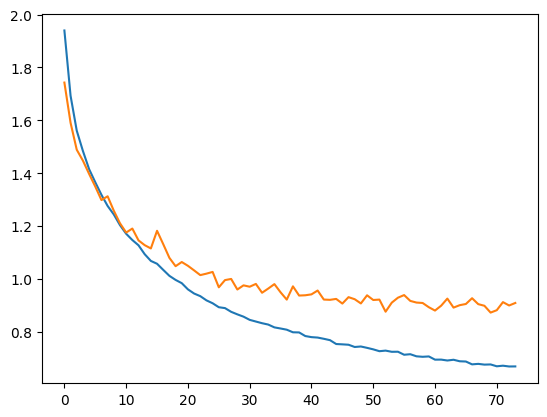

In [181]:
import matplotlib.pyplot as plt
plt.plot(losses_train)
plt.plot(losses_test)

In [182]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in tqdm(testloader):
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

100%|██████████| 40/40 [00:05<00:00,  7.03it/s]

Accuracy of the network on the 10000 test images: 69 %
